In [1]:
# Install imageio for creating animations.  
!pip -q install imageio
!pip -q install scikit-image
!pip install -q git+https://github.com/tensorflow/docs

In [1]:
import tensorflow_hub as hub

progan = hub.load("https://tfhub.dev/google/progan-128/1").signatures['default']


2023-03-07 00:58:46.142226: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 00:58:48.563144: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from absl import logging
from PIL import Image

import imageio
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
tf.random.set_seed(0)

import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import time

try:
  from google.colab import files
except ImportError:
  pass

from IPython import display
from skimage import transform

# We could retrieve this value from module.get_input_shapes() if we didn't know
# beforehand which module we will be using.
latent_dim = 512


# Interpolates between two vectors that are non-zero and don't both lie on a
# line going through origin. First normalizes v2 to have the same norm as v1. 
# Then interpolates between the two vectors on the hypersphere.
def interpolate_hypersphere(v1, v2, num_steps):
  v1_norm = tf.norm(v1)
  v2_norm = tf.norm(v2)
  v2_normalized = v2 * (v1_norm / v2_norm)

  vectors = []
  for step in range(num_steps):
    interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
    interpolated_norm = tf.norm(interpolated)
    interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
    vectors.append(interpolated_normalized)
  return tf.stack(vectors)

# Simple way to display an image.
def display_image(image):
  image = tf.constant(image)
  image = tf.image.convert_image_dtype(image, tf.uint8)
  return PIL.Image.fromarray(image.numpy())

# Given a set of images, show an animation.
def animate(images):
  images = np.array(images)
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images)
  return embed.embed_file('./animation.gif')

logging.set_verbosity(logging.ERROR)

In [25]:
import os
print(os.getcwd())



/Users/xuxuqian/Documents/MSc-Coding-2-master/Week-7-notebooks


In [3]:
image = Image.open("/Users/xuxuqian/Desktop/000025.jpg")
image = image.resize((128, 128))


In [4]:
image_array = np.array(image) / 255.0


In [5]:
image_tensor = tf.convert_to_tensor(image_array)
image_tensor = tf.reshape(image_tensor, [1, 128, 128, 3])

In [6]:
image_tensor = tf.cast(image_tensor, dtype=tf.float32)

generated_image = progan(image_tensor)['default']




In [ ]:
def interpolate_between_vectors():
  v1 = tf.random.normal([latent_dim])
  v2 = tf.random.normal([latent_dim])
    
  # Creates a tensor with 25 steps of interpolation between v1 and v2.
  vectors = interpolate_hypersphere(v1, v2, 50)

  # Uses module to generate images from the latent space.
  interpolated_images = progan(vectors)['default']

  return interpolated_images

interpolated_images = interpolate_between_vectors()
animate(interpolated_images)

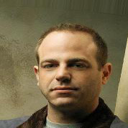

In [8]:
image_from_module_space = True  # @param { isTemplate:true, type:"boolean" }

def get_module_space_image():
  vector = tf.random.normal([1, latent_dim])
  images = progan(vector)['default'][0]
  return images

def upload_image():
  uploaded = files.upload()
  image = imageio.imread(uploaded[list(uploaded.keys())[0]])
  return transform.resize(image, [128, 128])


target_image = np.array(image)
target_image = tf.cast(target_image, tf.float64)

target_image = target_image / 255.0 # Normalize the pixels in the image
display_image(target_image)


In [9]:
tf.random.set_seed(42)
initial_vector = tf.random.normal([1, latent_dim])

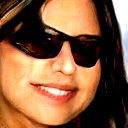

In [10]:
display_image(progan(initial_vector)['default'][0])

In [32]:
def find_closest_latent_vector(initial_vector, num_optimization_steps, steps_per_image):
  images = []
  losses = []

  vector = tf.Variable(initial_vector)  
  optimizer = tf.optimizers.Adam(learning_rate=0.03)
  loss_fn = tf.losses.MeanAbsoluteError(reduction="sum")
  reg_fn = tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)

  for step in range(num_optimization_steps):
    if (step % 100)==0:
      print()
    print('.', end='')
    with tf.GradientTape() as tape:
      image = progan(vector.read_value())['default'][0]
      target_image_difference = loss_fn(image, tf.cast(target_image[:,:,:3], tf.float32))
      if (step % steps_per_image) == 0:
        images.append(image.numpy())
      # Apply regularizer to latent vector
      regularizer = reg_fn(vector)
      
      loss = target_image_difference + regularizer
      losses.append(loss.numpy())
    grads = tape.gradient(loss, [vector])
    optimizer.apply_gradients(zip(grads, [vector]))
    
  return images, losses

num_optimization_steps = 400
steps_per_image = 3
images, loss = find_closest_latent_vector(initial_vector, num_optimization_steps, steps_per_image)





....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

(0.0, 5664.330236816406)

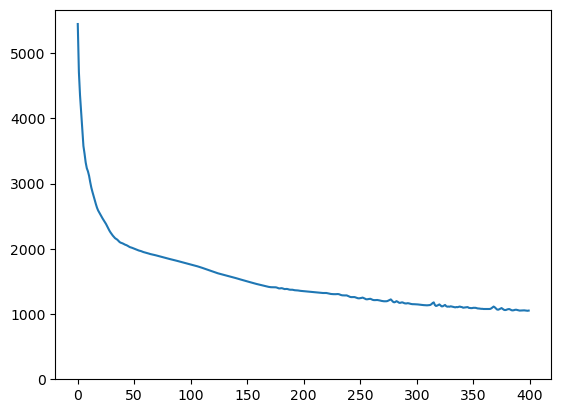

In [34]:
plt.plot(loss)
plt.ylim([0,max(plt.ylim())])


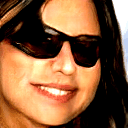

In [35]:
animate(np.stack(images))

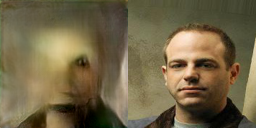

In [36]:
display_image(np.concatenate([images[-1], target_image], axis=1))